# School mode choice model k-12 students

Estimate mode choice for school ralated trips

To improve: 
- Verify trips tables
- Check students with school ID table

In [1]:
import numpy as np
import pandas as pd
import orca
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import os; os.chdir('../../')
import warnings; warnings.simplefilter('ignore')

import pandana as pdna
from collections import OrderedDict
import pylogit as pl
from pylogit import nested_logit as nl
import math 
import pickle
import dill
import time
import random
import scipy.stats as st
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
    
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
from urbansim.utils import misc
import urbansim_templates

from scripts import datasources, models, variables, utils

Registering model step 'auto_ownership'
Registering model step 'WLCM_gen_tt'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'


In [2]:
input_file_format = 'csv'
input_data_dir = '/home/data/spring_2019/base/'

formattable_fname_dict = {
    'parcels': 'parcels.{0}',
    'buildings': 'buildings.{0}',
    'jobs': 'jobs.{0}',
    'establishments': 'establishments.{0}',
    'households': 'households.{0}',
    'persons': 'persons.{0}',
    'rentals': 'craigslist.{0}',
    'units': 'units.{0}',
    'mtc_skims': 'mtc_skims.{0}',
    'beam_skims_raw': '30.skims-smart-23April2019-baseline.csv.gz',
    'beam_skims_imputed': 'beam_skims_imputed.{0}',
    # the following nodes and edges .csv's will be phased out and
    # replaced by travel model skims entirely
    'drive_nodes': 'drive_nodes.{0}',
    'drive_edges': 'drive_edges.{0}',
    'drive_access_vars': 'drive_net_vars.{0}',
    'walk_nodes': 'walk_nodes.{0}',
    'walk_edges': 'walk_edges.{0}',
    'walk_access_vars': 'walk_net_vars.{0}',
    'zones': 'zones.{0}',
    'zone_access_vars': 'zones_w_access_vars.{0}',
}

def format_fname_dict(formattable_fname_dict, format='csv'):
    formatted_dict = {
        k: v.format('csv')
        for k, v in formattable_fname_dict.items()}
    return formatted_dict

input_fnames = format_fname_dict(
            formattable_fname_dict, input_file_format)

In [3]:
orca.add_injectable('input_file_format', input_file_format)
orca.add_injectable('input_data_dir', input_data_dir)
orca.add_injectable('input_fnames', input_fnames)
orca.add_injectable('store', None)

In [4]:
orca.run(['initialize_network_small']) 
orca.run([ 'initialize_network_walk']) 
orca.run(['initialize_imputed_skims']) 
orca.run(['skims_aggregations']) 

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s
Running step 'initialize_imputed_skims'
No imputed skims found. Creating them now.
Time to execute step 'initialize_imputed_skims': 88.97 s
Total time to execute iteration 1 with iteration value None: 88.97 s
Running step 'skims_aggregations'
Time to execute step 'skims_aggregations': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


## Loading data

In [5]:
trips = pd.read_csv('/home/emma/ual_model_workspace/spring-2019-models/notebooks-emma/HStrips_031219.csv', index_col = 0)
students = pd.read_csv('/home/juan/ual_model_workspace/spring-2019-models/notebooks-juan/students_with_school_id.csv')
persons = pd.read_csv('/home/data/fall_2018/chts_persons_w_zone_ids.csv')
households = pd.read_csv("/home/data/fall_2018/CHTS_csv_format/data/Deliv_HH.csv")
zones = orca.get_table('zones').to_frame()
beam_skims = orca.get_table('beam_skims_imputed').to_frame().reset_index()
schools = orca.get_table('schools').to_frame()

## Data merging

- Merges students, households and time-based accesibility variables
- Merges travel time and travel cost (beam skims) 

In [7]:
#select people who make both home-school and school-home trips:
tripsII = trips.groupby('HHPER').filter(lambda x: len(x) == 2)

tripsIII = tripsII.sort_values(['HHPER','origin'])

#move school-home trip info up into home-school trip rows
tripsIII['school_dwell'] = tripsIII.groupby('HHPER', group_keys=False).origin_dwell.shift(-1)
tripsIII['school_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ST.shift(-1)
tripsIII['SH_trip_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ET.shift(-1)
tripsIII['SH_trip_ET'] = tripsIII.groupby('HHPER', group_keys=False).trip_ET.shift(-1)
tripsIII['SH_TT'] = tripsIII.groupby('HHPER', group_keys=False).TT.shift(-1)
tripsIII['SH_mode'] = tripsIII.groupby('HHPER', group_keys=False).MODE.shift(-1)

tripsIII = tripsIII.groupby('HHPER').first().reset_index()

tripsIII.rename(columns = {'origin_dwell':'home_dwell',
                           'origin_ST':'home_ST',
                           'origin_ET':'HS_trip_ST',
                           'trip_ET':'HS_trip_ET',
                           'TT':'HS_TT',
                           'MODE':'HS_mode',
                           'TOD':'HS_TOD'},
                inplace = True)

tripsIII['SAMPN'] = [ str(x)[:-1] for x in tripsIII.HHPER]
tripsIII['SAMPN'] = tripsIII['SAMPN'].astype(int)

tripsIII['PERNO'] = [ str(x)[-1:] for x in tripsIII.HHPER]
tripsIII['PERNO'] = tripsIII['PERNO'].astype(int)

# % HS and SH trips in the same mode. 
(tripsIII.HS_mode == tripsIII.SH_mode).sum()/len(tripsIII)*100

87.70416962564674

In [8]:
#Students data
# students = persons.loc[persons['STUDE'].isin([1, 2])# full time & part time students
#                  & persons['SCHOL'].isin([3,  # Kindergarten to grade 8
#                                           4])  # Grades 9 to 12 
#                  & (~persons['SNAME_lookup'].isna()) 
#                  & (persons['SNAME_lookup'] != "DK/RF")]

# students['HHPER'] = (students['SAMPN'].map(str) + students['PERNO'].map(str)).astype(int)
students = pd.read_csv('/home/juan/ual_model_workspace/spring-2019-models/notebooks-juan/students_with_school_id.csv')

not_include = ['WNAME_lookup', 'WCITY_lookup', 'WZIP_lookup',
       'WXST1_lookup', 'WXST2_lookup', 'WXCORD_lookup', 'WYCORD_lookup',
       'WNAME2_lookup', 'WCITY2_lookup', 'WZIP2_lookup', 'WXST2_1_lookup',
       'WXST2_2_lookup', 'SNAME_lookup', 'SCITY_lookup', 'SZIP_lookup',
       'SXST1_lookup', 'SXST2_lookup', 'SXCORD_lookup', 'SYCORD_lookup',
       'WCTFIP_lookup', 'WTRACT_lookup', 'WBLOCK', 'WPrimaryCity_lookup',
       'WSTFIP_lookup', 'W2PrimaryCity_lookup', 'W2STFIP_lookup',
       'SCTFIP_lookup', 'STRACT_lookup', 'SBLOCK', 'SPrimaryCity_lookup',
       'SSTFIP_lookup', 'HCITY', 'HZIP', 'HXCORD', 'HYCORD', 'HBLOCK',
       'HTRACT', 'HCTFIP', 'HPrimaryCity', 'parcel_id_home', 'parcel_id_work',
       'zone_id_work', 'Unnamed: 0', 'index']

students = students.drop(columns=not_include)

#Merging race columns to just 1 (consistent with PUMPS race classification)
students['race'] = students.RACE1.notnull().astype(int) + \
                          students.RACE2.notnull().astype(int) + \
                          students.RACE3.notnull().astype(int) + \
                          students.RACE4.notnull().astype(int)

students['race'] = students['race'].replace(2, 6) # Two or more races (6. 2+ races)
students['race'] = np.where(students['race'] == 1, students['RACE1'], students['race'])

#Merging trip and students to select K-12 students
tripsIV = tripsIII.merge(students, how = 'left', on = ['SAMPN', 'PERNO'])

#Age cleaning
tripsIV.AGE.replace([998, 999, 99], np.nan, inplace = True) #NAN values CHTS documentation
tripsIV = tripsIV[tripsIV.AGE <= 18] #Filtering students older than 18 years (only 3)
tripsIV.dropna(subset=['AGE'], inplace = True)

################################################################################
################################################################################
## CHECK THIS MERGE ONLY HAS 53% OF STUDENTS.. THERE ARE SOME MISSING TRIPS ####
################################################################################
tripsIV.AGE.notnull().sum()

1792

In [9]:
#Merging household attributes
tripsV = tripsIV.merge(households, how = 'left', on = 'SAMPN')

In [10]:
# Merging zones
tripsVI = tripsV.merge(zones, how = 'left', left_on ='zone_id_home', right_index = True )

In [11]:
#Merging schools
tripsVII = tripsVI.merge(schools, how = 'left', left_on = 'school_id', right_index = True)

In [12]:
#Merging travel time and travel zones
tripsVIII = tripsVII.merge(beam_skims, 
                        how = 'left', 
                        left_on = ['zone_id_home','school_zone_id'], 
                        right_on = ['from_zone_id','to_zone_id'])

In [13]:
###############
#Merging additional hosuehold attributes based on the persons table 
##########################################

#Getting number of children per household, race and age of the head (head assume to be PERNO == 1)
persons['children'] = (persons.AGE < 18).astype(int)
# persons.loc[:,['RACE1', 'RACE2', 'RACE3', 'RACE4', 'O_RACE']]
persons['race_id'] = persons.RACE1.notnull().astype(int) + \
                          persons.RACE2.notnull().astype(int) + \
                          persons.RACE3.notnull().astype(int) + \
                          persons.RACE4.notnull().astype(int)

persons['race_id'] = persons['race_id'].replace(2, 6) # Two or more races (6. 2+ races)
persons['race_id'] = np.where(persons['race_id'] == 1, persons['RACE1'], persons['race_id'])


hh_per_var = persons.loc[:,['SAMPN', 'PERNO', 'children','race_id', 'AGE', 'HISP']].sort_values(['SAMPN', 'PERNO']).groupby('SAMPN').\
             agg({'children': 'sum', 'race_id': 'first', 'AGE': 'first', 'HISP': 'first'})

hh_per_var.rename(columns = {'AGE': 'age_of_head', 'race_id': 'race_head', 'HISP': 'hispanic_head'}, inplace = True)

tripsIX = tripsVIII.merge(hh_per_var, how = 'left', left_on = 'SAMPN', right_index = True )



In [14]:
df_trips = tripsIX
df_trips.shape

(1792, 350)

## Data preparation

In [15]:
df_trips.HS_trip_ET

0       7.833333
1       8.250000
2       7.250000
3       8.166667
4       7.833333
5       7.833333
6       8.416667
7       8.166667
8       7.866667
9       7.866667
10      7.800000
11      7.800000
12      8.200000
13      8.200000
14      7.500000
15      8.083333
16      7.933333
17      8.083333
18      7.916667
19      7.683333
20      7.500000
21      8.333333
22      8.333333
23      8.333333
24      6.833333
25      8.000000
26      8.250000
27      7.283333
28      7.900000
29      9.466667
          ...   
1762    7.750000
1763    8.083333
1764    7.916667
1765    7.916667
1766    8.000000
1767    6.666667
1768    6.666667
1769    7.916667
1770    8.050000
1771    7.750000
1772    7.833333
1773    7.966667
1774    7.666667
1775    8.333333
1776    8.550000
1777    8.166667
1778    7.833333
1779    8.116667
1780    8.116667
1781    7.616667
1782    8.250000
1783    8.233333
1784    8.316667
1785    8.266667
1786    7.833333
1787    8.250000
1788    7.666667
1789    7.5833

In [16]:
 #adding recent mover varible
df_trips['recent_mover'] = (df_trips.TEN <= 5).astype(int)

#Naming varaibles as in PUMS varaibles
pums_names = {'HHSIZ': 'persons', 'INCOM': 'income', 'OWN': 'tenure', 'HHVEH': 'cars', 'HHEMP': 'workers', 
              'AGE': 'age', 'SCHOL': 'education', 'GEND': 'sex', 'HISP': 'hispanic', 'HS_trip_ET': 'HS_ET'}

df_trips.rename(columns=pums_names, inplace = True)

# Replacing na keys to real na's
na_dict = {
    'race':[98, 99],
    'hispanic':[8, 9],
    'sex':[9],
    'income':[98,99],
    'tenure':[7, 8, 9],
    'race_head':[98, 99],
    'hispanic_head':[8, 9],
    'age_of_head': [998, 999],
    }

for col in na_dict:
    for vals in na_dict[col]:
        df_trips[col] = df_trips[col].replace(vals,np.nan)

df_trips.shape

(1792, 351)

In [17]:
## Preparing data for ML models

# Replacing mode string categories with number categories
df_trips['trip_mode'] = df_trips['HS_mode'].replace(['drive_alone', 
                                                     'shared', 'walk', 
                                                     'bike', 'WTranW', 
                                                     'DrTranW', 'WSBusW'],
                                                    [1,2,3,4,5,6,7])

#Race dictionary
race_dict = {1.0 :'white', 2.0 : 'african_american', 3.0 : 'indian/alaska', 
             4.0 : 'asian', 5.0 : 'hawaii/pacific', 6.0 : '2+races', 97.0 : 'other'}

#Replace race with values in race dictionary
df_trips.race.replace(race_dict, inplace = True)
df_trips.race_head.replace(race_dict, inplace = True)

# Dummy variables
df_trips.education.replace([3.0, 4.0], [0, 1], inplace = True) # 0:k-8, 1:9-12
df_trips.hispanic.replace([1.0, 2.0], [1, 0], inplace = True) # 0:non-hispanic, 1:hispanic
df_trips.sex.replace([1.0, 2.0], [0, 1], inplace = True) # 0:male, 1:female
df_trips.tenure.replace([1.0, 2.0], [0, 1], inplace = True) # 0:own_house, 1:rent_house
df_trips.tenure.replace([1.0, 2.0], [0, 1], inplace = True) # 0:own_house, 1:rent_house
df_trips.hispanic_head.replace([1.0, 2.0], [1, 0], inplace = True) # 0:non-hispanic, 1:hispanic
df_trips.type.replace(['public', 'private'], [0, 1], inplace = True) # 0:public school, 1:private school

#One hot enconde race variables
race_dummies = pd.get_dummies(df_trips.race, prefix = 'race')
head_race_dummies = pd.get_dummies(df_trips.race_head, prefix = 'race_head')

#Concatenate one hot encoded dataframes
df = pd.concat([df_trips,race_dummies, head_race_dummies], axis = 1)
df.shape

(1792, 366)

In [18]:
#Vars names
time_acc = list(set(zones.columns) - {'acres', 'area', 'gid'})
beam_var = list(set(beam_skims.columns) - {'from_zone_id', 'to_zone_id'})

#Categorical varaibles
cat_var = ['sex', 'tenure' , 'recent_mover',
           'hispanic_head','income'] + list(race_dummies.columns) + list(head_race_dummies.columns)

#Continous variables 
cont_vars = ['age', 'persons', 'cars', 'workers', 'children', 'age_of_head', 'HS_ET'] + time_acc + beam_var

total_vars = cat_var + cont_vars + ['trip_mode']
df = df.loc[:,total_vars + ['HHPER', 'SAMPN', 'PERNO', 'HS_TT']]

# Dropping na's
print ('Observation before dropping na = ' + str(df.shape[0]))
df.dropna(inplace = True)
print ('Observation after dropping na = ' + str(df.shape[0]))

Observation before dropping na = 1792
Observation after dropping na = 1656


In [19]:
tripsIV.columns

Index(['HHPER', 'HHPERTRIP', 'origin', 'home_dwell', 'home_ST', 'HS_trip_ST',
       'HS_trip_ET', 'HS_TT', 'HS_mode', 'school_dwell',
       ...
       'WSTFIP_persons', 'W2PrimaryCity_persons', 'W2STFIP_persons',
       'SPrimaryCity_persons', 'SSTFIP_persons', 'PERWGT', 'EXPPERWGT',
       'zone_id_home', 'school_id', 'race'],
      dtype='object', length=167)

In [20]:
# df['walk_time_minutes'] = df.HS_TT * 60
# df['dif_beam_chts'] = np.abs(df.gen_tt_WALK - df.walk_time_minutes)
# walk_matrix = df[df.trip_mode == 3][['SAMPN','gen_tt_WALK','walk_time_minutes','dif_beam_chts', 'HS_TT']]

# walk_matrix.sort_values(by = ['dif_beam_chts'], ascending = False)[walk_matrix.dif_beam_chts > 30]

# plt.hist(walk_matrix.dif_beam_chts, bins = 30)

## ML Approach

In [21]:
#Splitting train and test data

X = df.drop(columns =['trip_mode', 'HHPER', 'SAMPN', 'PERNO', 'HS_TT'])
y = df.trip_mode
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
X.sex.unique()

array([0., 1.])

In [23]:
# #Normalazing training data
# scaler = StandardScaler()
# column_names_to_normalize = cont_vars
# x = X_train[column_names_to_normalize]
# x_scaled = scaler.fit_transform(x)
# df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = X_train.index)
# X_train_nor = pd.concat([X_train[cat_var], df_temp], axis = 1)
X_train_nor = X_train

# #Normalazig test data
# x_test = X_test[column_names_to_normalize]
# x_test_scaled = scaler.transform(x_test)
# df_temp = pd.DataFrame(x_test_scaled, columns=column_names_to_normalize, index = X_test.index)
# X_test_nor = pd.concat([X_test[cat_var], df_temp], axis = 1)
X_test_nor = X_test

### Decision tree

In [24]:
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train_nor, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 

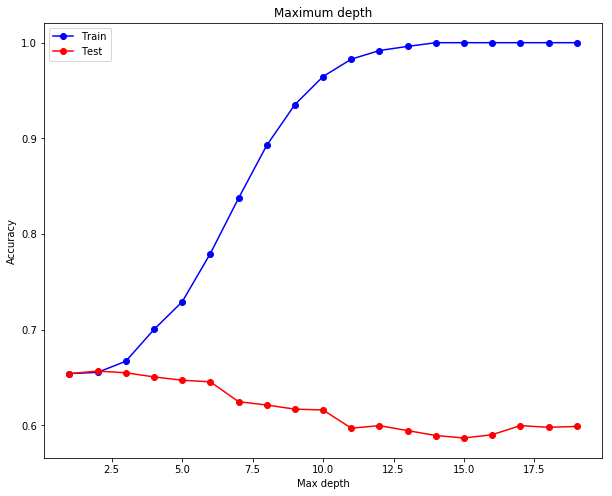

In [25]:
plt.figure(figsize = (10,8))
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Maximum depth')
plt.legend();

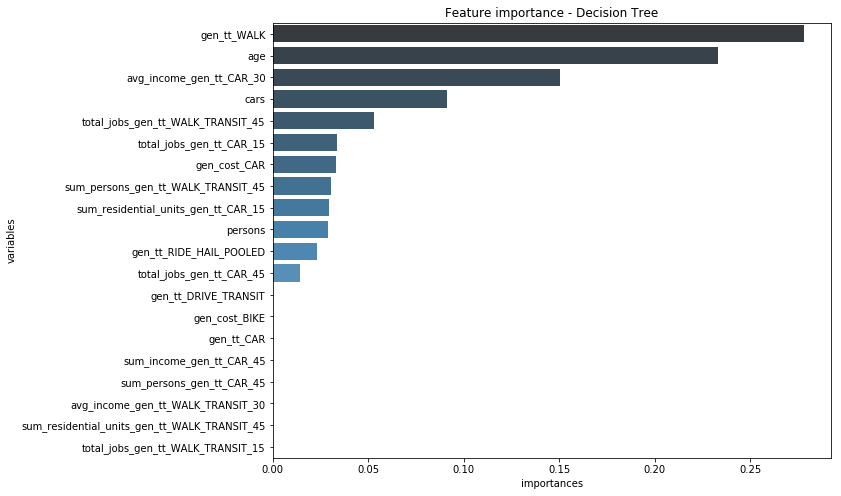

In [26]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=4)
clf.fit(X_train_nor, y_train);

aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train_nor.columns}).sort_values(by = 'importances', ascending= False)

plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=aa[:20],palette="Blues_d" )
plt.title('Feature importance - Decision Tree');

# aa[:20].plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
# plt.yticks();#(fontsize = 10)
# # plt.tight_layout()

In [27]:
pd.crosstab( y_test, clf.predict(X_test_nor))#,normalize = 'index')

col_0,1,2,3
trip_mode,,,
1,17,10,0
2,9,301,11
3,0,88,11
4,0,21,2
5,0,11,0
6,0,2,0
7,1,13,0


In [28]:
clf.score(X_test_nor, y_test)

0.6619718309859155

### Gradient boosting

In [29]:
X_train_nor.columns

Index(['sex', 'tenure', 'recent_mover', 'hispanic_head', 'income',
       'race_2+races', 'race_african_american', 'race_asian',
       'race_hawaii/pacific', 'race_indian/alaska', 'race_other', 'race_white',
       'race_head_2+races', 'race_head_african_american', 'race_head_asian',
       'race_head_hawaii/pacific', 'race_head_indian/alaska',
       'race_head_other', 'race_head_white', 'age', 'persons', 'cars',
       'workers', 'children', 'age_of_head', 'HS_ET',
       'sum_income_gen_tt_WALK_TRANSIT_15', 'sum_residential_units',
       'sum_persons_gen_tt_CAR_15', 'sum_income_gen_tt_CAR_15', 'total_jobs',
       'sum_residential_units_gen_tt_CAR_45', 'sum_persons',
       'sum_residential_units_gen_tt_CAR_15', 'sum_income',
       'sum_persons_gen_tt_WALK_TRANSIT_15', 'total_jobs_gen_tt_CAR_45',
       'total_jobs_gen_tt_CAR_15', 'sum_income_gen_tt_CAR_45',
       'sum_persons_gen_tt_CAR_45', 'avg_income_gen_tt_WALK_TRANSIT_30',
       'sum_residential_units_gen_tt_WALK_TRANSIT_

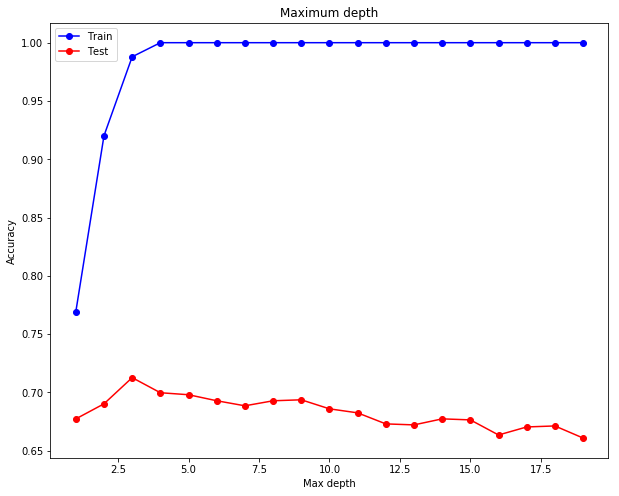

In [30]:
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = GradientBoostingClassifier(max_depth = i, n_estimators = 100)
    scores = cross_validate(clf, X_train_nor, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
    
plt.figure(figsize = (10,8))
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Maximum depth')
plt.legend();

In [31]:
X_train_nor

,sex,tenure,recent_mover,hispanic_head,income,race_2+races,race_african_american,race_asian,race_hawaii/pacific,race_indian/alaska,...,gen_cost_RIDE_HAIL_TRANSIT,gen_tt_RIDE_HAIL_TRANSIT,gen_tt_RIDE_HAIL,gen_cost_RIDE_HAIL,gen_cost_WALK_TRANSIT,gen_tt_WALK_TRANSIT,gen_tt_BIKE,gen_tt_CAR,gen_cost_CAR,gen_cost_WALK
188,0.0,0.0,0,0.0,8.0,1,0,0,0,0,...,2.763823,2.439422,2.765920,5.137312,98.328152,102.706749,7.180311,1.542595,1.017620,254.222399
603,0.0,0.0,1,0.0,7.0,0,0,0,0,0,...,11.649386,10.282048,11.658224,21.653529,414.448566,432.904147,30.264677,6.501967,4.289221,1071.535530
699,0.0,0.0,1,0.0,5.0,0,0,0,0,0,...,27.457423,24.234627,27.478254,51.037031,976.848837,1020.348354,71.333373,15.325034,10.109627,2525.592613
874,0.0,0.0,0,0.0,10.0,0,0,0,0,0,...,4.236140,3.738926,4.239354,7.874010,11.183519,27.933333,11.005337,2.364351,1.559717,389.649284
1400,0.0,0.0,0,0.0,8.0,0,0,0,0,1,...,23.376263,20.632490,23.393998,43.451094,831.653996,868.687921,60.730670,11.283333,4.444843,2150.198791
18,1.0,0.0,0,0.0,7.0,0,0,1,0,0,...,1.239846,1.094320,1.240787,2.304588,44.109825,46.074056,3.221074,0.692005,0.456502,114.043693
465,0.0,0.0,1,0.0,8.0,0,0,0,0,0,...,3.977839,3.510943,3.980857,7.393888,141.519022,147.820928,10.334280,2.220184,1.464612,365.890181
1196,0.0,0.0,0,1.0,5.0,0,0,0,0,0,...,1.730618,1.527488,1.731931,3.216821,61.569964,64.311702,4.496083,0.965924,0.637201,159.185988
304,0.0,0.0,0,0.0,2.0,0,0,1,0,0,...,1.833939,1.618682,1.835330,3.408870,65.245783,68.151207,4.764506,1.023591,0.675243,168.689629
1422,1.0,0.0,0,0.0,7.0,0,0,0,0,1,...,6.690002,5.904768,6.695078,12.435175,238.009265,248.607924,17.380380,3.733945,2.463211,615.360759


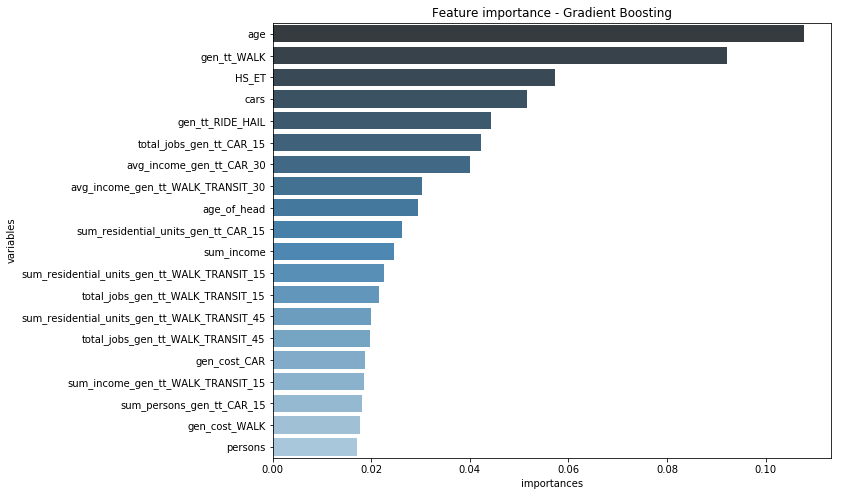

In [32]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=100)
model.fit(X_train_nor, y_train)

# importances = model.feature_importances_
# pd.crosstab( y_test, model.predict(X_test))
# model.score(X_test, y_test)

feat_importance = pd.DataFrame({'importances':model.feature_importances_,
                   'variables':X_train_nor.columns}).sort_values(by = 'importances', ascending= False)

plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=feat_importance[:20],palette="Blues_d" )
plt.title('Feature importance - Gradient Boosting');

In [33]:
pd.crosstab( y_test, model.predict(X_test_nor))

col_0,1,2,3,4,5,6,7
trip_mode,,,,,,,
1,14,10,1,2,0,0,0
2,6,286,18,8,1,0,2
3,2,48,45,4,0,0,0
4,1,15,1,5,0,1,0
5,0,6,1,1,3,0,0
6,0,1,0,0,0,1,0
7,1,10,0,0,0,0,3


In [34]:
model.score(X_test_nor, y_test)

0.7183098591549296

In [35]:
pd.Series(model.predict(X_test_nor)).value_counts()

2    376
3     66
1     24
4     20
7      5
5      4
6      2
dtype: int64

# MNL Model

In [36]:
#Splitting train and test data

X = df.drop(columns =['trip_mode'])
y = df.trip_mode
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
def wide_long_transformation(x,y):
    '''
    Wide to long transformation of a matrix and adding varaibles that matches the model specification
    x: Pandas dataframe with variables information
    y: Pandas dataframe/series with choice column
    '''
    data_wide = pd.concat([x, y], axis = 1)
    data_wide['obs_id'] = range(1, len(data_wide)+1)
    data_wide['cost_walk'] = 0
    
    # Creating availability varables
    modes = ['CAR', 'RIDE_HAIL', 'WALK', 'BIKE', 'WALK_TRANSIT', 'DRIVE_TRANSIT', 'SCHOOL_BUS']
    av_names = []
    
    for x in modes:
        av_name = 'av_'+str(x)
        av_names.append(av_name)
        data_wide[av_name] = 1
    
    #Preparing for transformation
    ind_variables = ['age', 'persons', 'cars', 'workers', 
                     'children', 'age_of_head', 'HS_ET', 
                     'dist'] + cat_var + time_acc
    
    alt_varying_variables = {u'travel_time': dict([(1, 'gen_tt_CAR'),
                                               (2, 'gen_tt_CAR'),
                                               (3, 'gen_tt_WALK'),
                                               (4, 'gen_tt_BIKE'),
                                               (5, 'gen_tt_WALK_TRANSIT'),
                                               (6, 'gen_tt_DRIVE_TRANSIT'),
                                               (7, 'gen_tt_WALK_TRANSIT')]),
                        u'travel_cost' : dict([(1, 'gen_cost_CAR'),
                                               (2, 'gen_cost_CAR'),
                                               (3, 'gen_cost_WALK'),
                                               (4, 'cost_walk'),
                                               (5, 'gen_cost_WALK_TRANSIT'),
                                               (6, 'gen_cost_DRIVE_TRANSIT'),
                                               (7, 'gen_cost_WALK_TRANSIT')])}

    availability_variables = dict(zip(range(1, 8), av_names))
    
    # Perform the desired conversion
    data_long = pl.convert_wide_to_long(wide_data= data_wide,
                                       ind_vars = ind_variables,
                                       alt_specific_vars = alt_varying_variables,
                                       availability_vars = availability_variables, 
                                       obs_id_col = 'obs_id',
                                       choice_col= 'trip_mode')
    
    #Adding variables to use in the specification
    data_long['travel_time:hrs'] = data_long['travel_time']/60
    data_long['ET_after_8'] = (data_long.HS_ET > 8).astype(int)
    data_long['avg_income_gen_tt_WALK_TRANSIT_30_200k'] = (data_long.avg_income_gen_tt_WALK_TRANSIT_30 < 200000).astype(int)
    data_long['sum_persons_gen_tt_WALK_TRANSIT_15_10k'] = (data_long.sum_persons_gen_tt_WALK_TRANSIT_15 > 10000).astype(int)
    data_long['avg_income_gen_tt_CAR_30_250k'] = (data_long.avg_income_gen_tt_CAR_30 > 250000).astype(int)
    data_long['total_jobs_gen_tt_CAR_15_160K'] = (data_long.total_jobs_gen_tt_CAR_15 > 160000).astype(int)
    data_long['income_7'] = (data_long.income <= 7).astype(int)
    data_long['age_0_12'] = (data_long.age < 12).astype(int)
    data_long['age_12_16'] = ((data_long.age >= 12) & (data_long.age < 16)).astype(int)
    data_long['age_16+'] = (data_long.age >= 16).astype(int)
    data_long['np.log1p(dist)'] = np.log1p(data_long.dist/1000)
    data_long["np.log1p(gen_cost)"] = np.log1p(data_long.travel_cost)
    data_long["np.log1p(gen_time)"] = np.log1p(data_long['travel_time:hrs'])
    data_long['np.log1p(dist):np.log1p(gen_cost)'] = data_long['np.log1p(dist)'] * data_long["np.log1p(gen_cost)"]
    
    return data_long

In [45]:
# sns.catplot(x="trip_mode", y="gen_tt_CAR", hue='hispanic',kind="box", data=data_wide);

In [46]:
 #Splitting train and test data

X = df.drop(columns =['trip_mode'])
y = df.trip_mode
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
df_long = wide_long_transformation(X_train, y_train)

In [49]:
# Model specification
mode_choice_specification = OrderedDict()
mode_choice_names = OrderedDict()

mode_choice_specification["intercept"] = [2, 3, 4, 5, 6, 7]
mode_choice_names["intercept"] = ['ASC_SHARED', 'ASC_WALK', 
                                  'ASC_BIKE', 'ASC_WALK_TRANSIT', 
                                  'ASC_DRIVE_TRANSIT', 'ASC_SCHOOL_BUS']

mode_choice_specification['travel_time:hrs'] = [[1, 2, 3, 4, 5, 6, 7]]
mode_choice_names['travel_time:hrs'] = ['GEN_TRAVEL_TIME:hrs']

mode_choice_specification["travel_cost"] = [[1, 2, 3, 4, 5, 6, 7]]
mode_choice_names["travel_cost"] = ['GEN_TRAVEL_cost']

mode_choice_specification['np.log1p(dist):np.log1p(gen_cost)'] = [[1,2,3,4,5,6,7]]
mode_choice_names['np.log1p(dist):np.log1p(gen_cost)'] = ['np.log1p(dist):np.log1p(gen_cost)']

mode_choice_specification["age_16+"] = [[2, 3, 4, 7],[5, 6]]
mode_choice_names["age_16+"] = ['age_16+_2_3_4_7','age_16+_5_6']

mode_choice_specification["cars"] = [[2, 3, 4, 6],[5,7]]
mode_choice_names["cars"] = ['car_2_3_4_5', 'car_5_7']

mode_choice_specification['ET_after_8'] = [2]
mode_choice_names['ET_after_8'] = ['ET_after_8_SHARED']

mode_choice_specification["age_of_head"] = [[3, 5]]
mode_choice_names["age_of_head"] = ['AGE_HEAD_3_5']

## Accesibility variables
mode_choice_specification['sum_persons_gen_tt_WALK_TRANSIT_15_10k'] = [4,6]
mode_choice_names['sum_persons_gen_tt_WALK_TRANSIT_15_10k'] = ['sum_persons_gen_tt_WALK_TRANSIT_15_10k',
                                                              'sum_persons_gen_tt_WALK_TRANSIT_15_10k']

mode_choice_specification['avg_income_gen_tt_CAR_30_250k'] = [2,4]
mode_choice_names['avg_income_gen_tt_CAR_30_250k'] = ['avg_income_gen_tt_CAR_30_250k',
                                                      'avg_income_gen_tt_CAR_30_250']

mode_choice_specification['total_jobs_gen_tt_CAR_15_160K'] = [[2, 3], [4, 5, 6]]
mode_choice_names['total_jobs_gen_tt_CAR_15_160K'] = ['total_jobs_gen_tt_CAR_15',
                                                      'total_jobs_gen_tt_CAR_15']

mode_choice_specification['income_7'] = [2, 3, 4, 5, 7]
mode_choice_names['income_7'] = ['income_7', 'income_7', 
                                            'income_7', 'income_7', 'income_7']

In [51]:
school_mode_choice = pl.create_choice_model(data=df_long,
                                     alt_id_col='alt_id',
                                     obs_id_col='obs_id',
                                     choice_col='trip_mode',
                                     specification=mode_choice_specification,
                                     model_type="MNL",
                                     names=mode_choice_names)

school_mode_choice.fit_mle(np.zeros(26))
school_mode_choice.get_statsmodels_summary()

Log-likelihood at zero: -2,255.3099
Initial Log-likelihood: -2,255.3099
Estimation Time for Point Estimation: 0.15 seconds.
Final log-likelihood: -1,062.8415


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                   trip_mode   No. Observations:                1,159
Model:             Multinomial Logit Model   Df Residuals:                    1,133
Method:                                MLE   Df Model:                           26
Date:                     Tue, 24 Sep 2019   Pseudo R-squ.:                   0.529
Time:                             14:40:29   Pseudo R-bar-squ.:               0.517
AIC:                             2,177.683   Log-Likelihood:             -1,062.842
BIC:                             2,309.121   LL-Null:                    -2,255.310
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
ASC_SHARED                                 6.9108      0.877      7.880      0.000       5.192       8.630
ASC_WALK                                   7.7148      0.983      7.850      0.000       5.789       9.641
ASC_BIKE                                   2.3065      1.012      2.279      0.023       0.323       4.291
ASC_WALK_TRANSIT                           5.1623      1.121      4.607      0.000       2.966       7.358
ASC_DRIVE_TRANSIT                          1.1995      1.016      1.180      0.238      -0.792       3.191
ASC_SCHOOL_BUS                             5.2148      1.000      5.214      0.000       3.255       7.175
GEN_TRAVEL_TIME:hrs                        0.1576      0.028      5.659      0.000       0.103       0.212
GEN_TRAVEL_cost                           -0.0032      0.001     -5.948      0.000      -0.004      -0.002
np.log1p(dist):np.log1p(gen_cost)          0.0940      0.043      2.212      0.027       0.011       0.177
age_16+_2_3_4_7                           -4.5737      0.613     -7.456      0.000      -5.776      -3.371
age_16+_5_6                               -3.0751      0.701     -4.389      0.000      -4.448      -1.702
car_2_3_4_5                               -0.8567      0.207     -4.145      0.000      -1.262      -0.452
car_5_7                                   -1.6893      0.279     -6.065      0.000      -2.235      -1.143
ET_after_8_SHARED                         -0.2010      0.133     -1.513      0.130      -0.461       0.059
AGE_HEAD_3_5                              -0.0331      0.009     -3.518      0.000      -0.051      -0.015
sum_persons_gen_tt_WALK_TRANSIT_15_10k    -0.2970      0.380     -0.781      0.435      -1.042       0.448
sum_persons_gen_tt_WALK_TRANSIT_15_10k     1.4918      0.679      2.198      0.028       0.162       2.822
avg_income_gen_tt_CAR_30_250k             -0.1546      0.153     -1.009      0.313      -0.455       0.146
avg_income_gen_tt_CAR_30_250               2.0968      0.462      4.541      0.000       1.192       3.002
total_jobs_gen_tt_CAR_15                   0.7859      0.255      3.083      0.002       0.286       1.286
total_jobs_gen_tt_CAR_15                   1.5093      0.351      4.295      0.000       0.821       2.198
income_7                                   0.6832      0.320      2.135      0.033       0.056       1.310
income_7                                   0.6623      0.346      1.911      0.056      -0.017       1.341
income_7                                   0.8169      0.411      1.988      0.047       0.012       1.622
income_7                                   0.6408      0.526      1.219      0.223      -0.390       1.671
income_7                                   0.4703      0.490      0.960      0.337      -0.490       1.430
=============================================================================================

In [52]:
# Just intercepts>> LL: -1,316.604
# Adding travel time & cost >> ll: -1,240.886
# Adding age varible >> ll:-1,130.597 [End up adding one dummy variable for students +16 years only]
# Addign cars variable >> ll:-1,088.894
# Adding ET time variable >> ll: -1,082.15 [How's a good improve, relation may not be linear]
# Just adding ET after 8 for sahred rides >> ll: -1,083.170
# Addingavg_income_gen_tt_WALK_TRANSIT_30 >> LL:-1,080.059
# Adding age of the head>> ll:-1,079.729

In [53]:
test_data = wide_long_transformation(X_test, y_test)

In [54]:
test_data['probabilities'] = school_mode_choice.predict(test_data)
mode_choice = test_data.sort_values("probabilities", ascending=False).groupby('obs_id').agg({'alt_id': 'first'})

In [55]:
pd.crosstab(y_test, mode_choice.alt_id.values)

col_0,1,2,3
trip_mode,,,
1,8,19,0
2,4,312,5
3,1,93,5
4,0,23,0
5,0,11,0
6,0,2,0
7,0,14,0


In [56]:
np.mean(y_test == mode_choice.alt_id.values)

0.6539235412474849

In [57]:
mode_choice.alt_id.value_counts()

2    474
1     13
3     10
Name: alt_id, dtype: int64

# Saving the models

In [58]:
#Creating a pkl file
file_Name = "/home/juan/activitysynth/activitysynth/configs/SMC_ml.pkl"
fileObject = open(file_Name,'wb') 
dill.dump(model,fileObject)   
fileObject.close()

In [59]:
#Testing pkl file
fileObject = open(file_Name,'rb')  
# load the object from the file into var b
b = pickle.load(fileObject)  
b.predict(X_test_nor)

array([2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2,
       3, 4, 4, 2, 2, 4, 2, 3, 2, 2, 2, 5, 2, 2, 1, 2, 2, 3, 2, 3, 2, 2,
       2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 4, 2, 3, 2, 2, 3, 2, 1, 2, 2, 3, 2,
       2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 3,
       3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3,
       2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 4, 2,
       2, 2, 2, 5, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 4, 2, 2, 2, 2,
       2, 2, 3, 2, 1, 2, 3, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 4, 2, 3, 3, 2, 2, 2, 1,
       2, 6, 2, 3, 2, 2, 3, 2, 2, 3, 2, 1, 2, 3, 7, 2, 2, 2, 2, 4, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 7, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
df.trip_mode.value_counts()